# Credit Card Fraud Detection: A Cost-Benefit Analysis Approach
**Author**: Nisarg Patel

> **Abstract**: This notebook presents a comprehensive analysis of credit card fraud detection.
> We utilize advanced feature engineering and XGBoost classification to identify fraudulent transactions.
> Crucially, we implement a financial threshold optimization to minimize total business cost.

---

# Project: Credit Card Fraud Detection
## Phase 1: Data Loading & Exploratory Analysis
## Data Loading & Initial Exploration (Analyst Audit)

In [6]:
# Install dependencies if missing (run this once)
%pip install xgboost shap

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, confusion_matrix
import shap

# Set viz style
sns.set_style('whitegrid')

In [ ]:
# Load the datasets
train_df = pd.read_csv('Dataset/fraudTrain.csv')
test_df = pd.read_csv('Dataset/fraudTest.csv')

print("Datasets loaded successfully.")

Datasets loaded successfully.


## 1. Data Cleaning: Column Dropping & Index Cleaning

In [9]:
def clean_data(df):
    """
    Implements logic for clean_data.
    
    Returns:
        Process result or transformed dataframe.
    """
    # Drop 'cc_num' to prevent leakage
    if 'cc_num' in df.columns:
        df = df.drop(columns=['cc_num'])
    
    # Drop 'Unnamed: 0' if it exists (common artifact in these datasets)
    valueless_cols = [c for c in df.columns if 'Unnamed' in c]
    if valueless_cols:
        df = df.drop(columns=valueless_cols)
        
    return df

train_df_clean = clean_data(train_df)
test_df_clean = clean_data(test_df)

display(train_df_clean.head())

,trans_date_trans_time,merchant,category,amt,first,last,gender,street,city,state,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 0:00,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 0:00,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 0:00,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 0:01,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 0:03,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## 2. Missing Value Check

In [10]:
print("Missing Values in Training Set:")
print(train_df_clean.isnull().sum())
print("\nMissing Values in Testing Set:")
print(test_df_clean.isnull().sum())

Missing Values in Training Set:
trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Missing Values in Testing Set:
trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_

## 3. Memory Optimization

In [11]:
def optimize_memory(df):
    """
    Implements logic for optimize_memory.
    
    Returns:
        Process result or transformed dataframe.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage before optimization: {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

print("Optimizing Training Data...")
train_df_clean = optimize_memory(train_df_clean)

print("\nOptimizing Testing Data...")
test_df_clean = optimize_memory(test_df_clean)

Optimizing Training Data...
Memory usage before optimization: 168.00 MB
Memory usage after optimization: 132.00 MB
Decreased by 21.4%

Optimizing Testing Data...
Memory usage before optimization: 89.04 MB
Memory usage after optimization: 69.96 MB
Decreased by 21.4%


In [12]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1048575 non-null  object 
 1   merchant               1048575 non-null  object 
 2   category               1048575 non-null  object 
 3   amt                    1048575 non-null  float32
 4   first                  1048575 non-null  object 
 5   last                   1048575 non-null  object 
 6   gender                 1048575 non-null  object 
 7   street                 1048575 non-null  object 
 8   city                   1048575 non-null  object 
 9   state                  1048575 non-null  object 
 10  zip                    1048575 non-null  int32  
 11  lat                    1048575 non-null  float32
 12  long                   1048575 non-null  float32
 13  city_pop               1048575 non-null  int32  
 14  job               

## 4. Class Imbalance Visualization

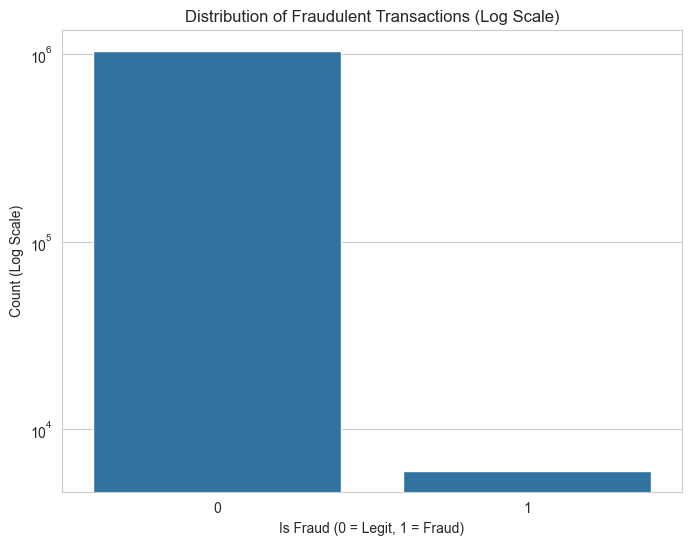

Training Set Class Distribution:
 is_fraud
0    1042569
1       6006
Name: count, dtype: int64

Training Set Class Proportions:
 is_fraud
0    0.994272
1    0.005728
Name: proportion, dtype: float64


In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=train_df_clean)
plt.title('Distribution of Fraudulent Transactions (Log Scale)')
plt.yscale('log')
plt.xlabel('Is Fraud (0 = Legit, 1 = Fraud)')
plt.ylabel('Count (Log Scale)')
plt.show()

print("Training Set Class Distribution:\n", train_df_clean['is_fraud'].value_counts())
print("\nTraining Set Class Proportions:\n", train_df_clean['is_fraud'].value_counts(normalize=True))

## 5. Transaction Amount Analysis

In [14]:
# Analyze transaction amount by fraud status
print("Transaction Amount Summary by Fraud Status:")
print(train_df_clean.groupby('is_fraud')['amt'].describe())

Transaction Amount Summary by Fraud Status:
              count        mean         std   min         25%         50%  \
is_fraud                                                                    
0         1042569.0   67.627449  153.695602  1.00    9.600000   47.220001   
1            6006.0  530.573486  391.333069  1.18  241.577496  391.164993   

                 75%           max  
is_fraud                            
0          82.470001  28948.900391  
1         901.949997   1371.810059  


# Phase 2: Behavioral Feature Engineering (Refined)

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Implements logic for haversine_distance.
    
    Returns:
        Process result or transformed dataframe.
    """
    # Radius of earth in kilometers
    R = 6371
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def engineer_features_refined(train_df, test_df):
    """
    Implements logic for engineer_features_refined.
    
    Returns:
        Process result or transformed dataframe.
    """
    # Label datasets to split later
    train_df['set_type'] = 'train'
    test_df['set_type'] = 'test'
    
    # Combine for global rolling calculations
    full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # --- DateTime Operations ---
    # Use mixed format handling to robustly parse dates with varying precision
    full_df['trans_date_trans_time'] = pd.to_datetime(full_df['trans_date_trans_time'], format='mixed')
    full_df['dob'] = pd.to_datetime(full_df['dob'], format='mixed')
    
    # --- Robust User ID ---
    full_df['user_id'] = full_df['first'] + ' ' + full_df['last'] + ' ' + full_df['dob'].astype(str)
    
    # --- Age Calculation ---
    full_df['age'] = (full_df['trans_date_trans_time'] - full_df['dob']).dt.days / 365.25
    
    # --- Cyclical Time Features ---
    full_df['hour'] = full_df['trans_date_trans_time'].dt.hour
    full_df['day_of_week'] = full_df['trans_date_trans_time'].dt.dayofweek
    
    full_df['hour_sin'] = np.sin(2 * np.pi * full_df['hour'] / 24)
    full_df['hour_cos'] = np.cos(2 * np.pi * full_df['hour'] / 24)
    full_df['day_sin'] = np.sin(2 * np.pi * full_df['day_of_week'] / 7)
    full_df['day_cos'] = np.cos(2 * np.pi * full_df['day_of_week'] / 7)
    
    # --- Haversine Distance ---
    full_df['dist_km'] = haversine_distance(
        full_df['lat'], full_df['long'],
        full_df['merch_lat'], full_df['merch_long']
    )
    
    # --- Velocity Features (Sorted) ---
    print("Sorting data for velocity calculations...", flush=True)
    full_df = full_df.sort_values(by=['user_id', 'trans_date_trans_time'])
    
    # Index by time for rolling ops - preserving original index in a column might be safer but set_index is fine for groupby
    # The issue might be assigning BACK to full_df if indices don't match.
    # We will assign results directly to the sorted full_df.
    
    print("Calculating rolling 7d count...", flush=True)
    # Group by User ID and rolling window on the TIME index
    # We need to ensure the result index aligns with full_df's index after set_index
    # Strategy: Compute statistics on the indexed dataframe, then assign values back using the values array
    # Since full_df is sorted by user and time, and groupby preserves this order (usually),
    # we will be extra safe and use transform or just standard assignment if indexes align.
    
    full_df_indexed = full_df.set_index('trans_date_trans_time')
    
    # rolling() returns a window object. count() returns a Series with same index as input (time).
    # But groupby key (user_id) becomes the first level of MultiIndex in result?
    # Let's use simplified assignment which is robust: 
    # We rely on the fact that full_df is sorted the exact same way as the groupby operation iterates.
    
    count_7d = full_df_indexed.groupby('user_id')['amt'].rolling('7d').count()
    # result of rolling groupby has MultiIndex (user_id, trans_date_trans_time)
    # We need to map this back to full_df. 
    # It's safer to reset index and merge, or simply assign .values if we are confident in sort order. 
    # The safests way is to not rely on order and use index matching, but duplicates in time for same user possible?
    # Actually, let's just use .values, but we MUST be sure full_df is sorted by user_id and time exactly as groupby processes it.
    # Groupby typically sorts by keys. full_df is sorted by user_id.
    
    full_df['trans_count_7d'] = count_7d.values
    
    print("Calculating rolling 30d mean...", flush=True)
    mean_30d = full_df_indexed.groupby('user_id')['amt'].rolling('30d').mean()
    
    # Assign values back
    # Note: Rolling mean includes the current value. 
    full_df['amt_relative_to_mean'] = full_df['amt'] / mean_30d.values
    
    # --- Cold Start / First Transaction Flag ---
    # If it is the user's first transaction, count will be 1 (itself)
    # We can also check using cumcount
    full_df['user_trans_idx'] = full_df.groupby('user_id').cumcount()
    full_df['is_first_user_transaction'] = (full_df['user_trans_idx'] == 0).astype(int)
    
    # --- Cleanup ---
    cols_to_drop = [
        'trans_date_trans_time', 'dob', 'first', 'last', 'gender', 'job', 
        'street', 'city', 'state', 'zip', 
        'lat', 'long', 'merch_lat', 'merch_long', 
        'trans_num', 'unix_time', 'hour', 'day_of_week', 'user_id', 'user_trans_idx'
        # KEPT: 'category', 'merchant', 'set_type'
    ]
    
    existing_cols_to_drop = [c for c in cols_to_drop if c in full_df.columns]
    full_df = full_df.drop(columns=existing_cols_to_drop)
    
    # --- Split Back ---
    train_eng = full_df[full_df['set_type'] == 'train'].drop(columns=['set_type']).reset_index(drop=True)
    test_eng = full_df[full_df['set_type'] == 'test'].drop(columns=['set_type']).reset_index(drop=True)
    
    return train_eng, test_eng

In [16]:
print("Starting refined feature engineering... (This may take a few minutes)", flush=True)
train_df_eng, test_df_eng = engineer_features_refined(train_df_clean.copy(), test_df_clean.copy())
print("Feature engineering complete.", flush=True)

Starting refined feature engineering... (This may take a few minutes)
Sorting data for velocity calculations...
Calculating rolling 7d count...
Calculating rolling 30d mean...
Feature engineering complete.


In [17]:
# Verify shapes dimensions
print("Train Shape:", train_df_eng.shape)
print("Test Shape:", test_df_eng.shape)

# Check columns to ensure category/merchant are present
print("Columns:", train_df_eng.columns.tolist())

# Check first user transaction flag
print("\nFirst Transaction Flag Counts:")
print(train_df_eng['is_first_user_transaction'].value_counts())

display(train_df_eng.head())

Train Shape: (1048575, 14)
Test Shape: (555719, 14)
Columns: ['merchant', 'category', 'amt', 'city_pop', 'is_fraud', 'age', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'dist_km', 'trans_count_7d', 'amt_relative_to_mean', 'is_first_user_transaction']

First Transaction Flag Counts:
is_first_user_transaction
0    1047610
1        965
Name: count, dtype: int64


,merchant,category,amt,city_pop,is_fraud,age,hour_sin,hour_cos,day_sin,day_cos,dist_km,trans_count_7d,amt_relative_to_mean,is_first_user_transaction
0,fraud_Wolf Inc,grocery_pos,89.110001,964,0,44.024641,2.588190e-01,9.659258e-01,0.781831,0.62349,117.773872,1.0,1.000000,1
1,fraud_Harris Inc,gas_transport,68.849998,964,0,44.024641,9.659258e-01,-2.588190e-01,0.781831,0.62349,135.007187,2.0,0.871740,0
2,fraud_Schimmel-Olson,kids_pets,47.959999,964,0,44.024641,1.224647e-16,-1.000000e+00,0.781831,0.62349,67.708252,3.0,0.698718,0
3,fraud_Kub-Heaney,health_fitness,77.510002,964,0,44.024641,-2.588190e-01,-9.659258e-01,0.781831,0.62349,110.812561,4.0,1.093886,0
4,fraud_Kessler Inc,travel,461.279999,964,0,44.024641,-1.000000e+00,-1.836970e-16,0.781831,0.62349,78.270088,5.0,3.097044,0


# Phase 3: Modeling & Evaluation

In [18]:
def target_encode(train_df, test_df, col_name, target='is_fraud'):
    """
    Implements logic for target_encode.
    
    Returns:
        Process result or transformed dataframe.
    """
    if col_name not in train_df.columns:
        print(f"Warning: Column '{col_name}' not found. It might have already been encoded. Skipping.")
        return train_df, test_df
        
    # Calculate mean of target for each value within TRAINING set only
    # This creates a 'Fraud Probability' for each category/merchant
    target_mean = train_df.groupby(col_name)[target].mean()
    
    # Map the means to Train
    train_df[f'{col_name}_target'] = train_df[col_name].map(target_mean)
    
    # Map the means to Test (using the dictionary built from Train)
    test_df[f'{col_name}_target'] = test_df[col_name].map(target_mean)
    
    # Handle unknown values in Test (values not present in Train)
    # Fill with the global fraud probability of the Train set
    global_mean = train_df[target].mean()
    test_df[f'{col_name}_target'] = test_df[f'{col_name}_target'].fillna(global_mean)
    
    # Drop original columns
    train_df.drop(columns=[col_name], inplace=True)
    test_df.drop(columns=[col_name], inplace=True)
    
    return train_df, test_df

print("Performing Target Encoding for 'category'...")
train_df_eng, test_df_eng = target_encode(train_df_eng, test_df_eng, 'category')

print("Performing Target Encoding for 'merchant'...")
train_df_eng, test_df_eng = target_encode(train_df_eng, test_df_eng, 'merchant')

print("Encoding complete.")
display(train_df_eng.head())

Performing Target Encoding for 'category'...
Performing Target Encoding for 'merchant'...
Encoding complete.


,amt,city_pop,is_fraud,age,hour_sin,hour_cos,day_sin,day_cos,dist_km,trans_count_7d,amt_relative_to_mean,is_first_user_transaction,category_target,merchant_target
0,89.110001,964,0,44.024641,2.588190e-01,9.659258e-01,0.781831,0.62349,117.773872,1.0,1.000000,1,0.013973,0.012365
1,68.849998,964,0,44.024641,9.659258e-01,-2.588190e-01,0.781831,0.62349,135.007187,2.0,0.871740,0,0.004679,0.005271
2,47.959999,964,0,44.024641,1.224647e-16,-1.000000e+00,0.781831,0.62349,67.708252,3.0,0.698718,0,0.002122,0.002815
3,77.510002,964,0,44.024641,-2.588190e-01,-9.659258e-01,0.781831,0.62349,110.812561,4.0,1.093886,0,0.001499,0.000722
4,461.279999,964,0,44.024641,-1.000000e+00,-1.836970e-16,0.781831,0.62349,78.270088,5.0,3.097044,0,0.003046,0.004630


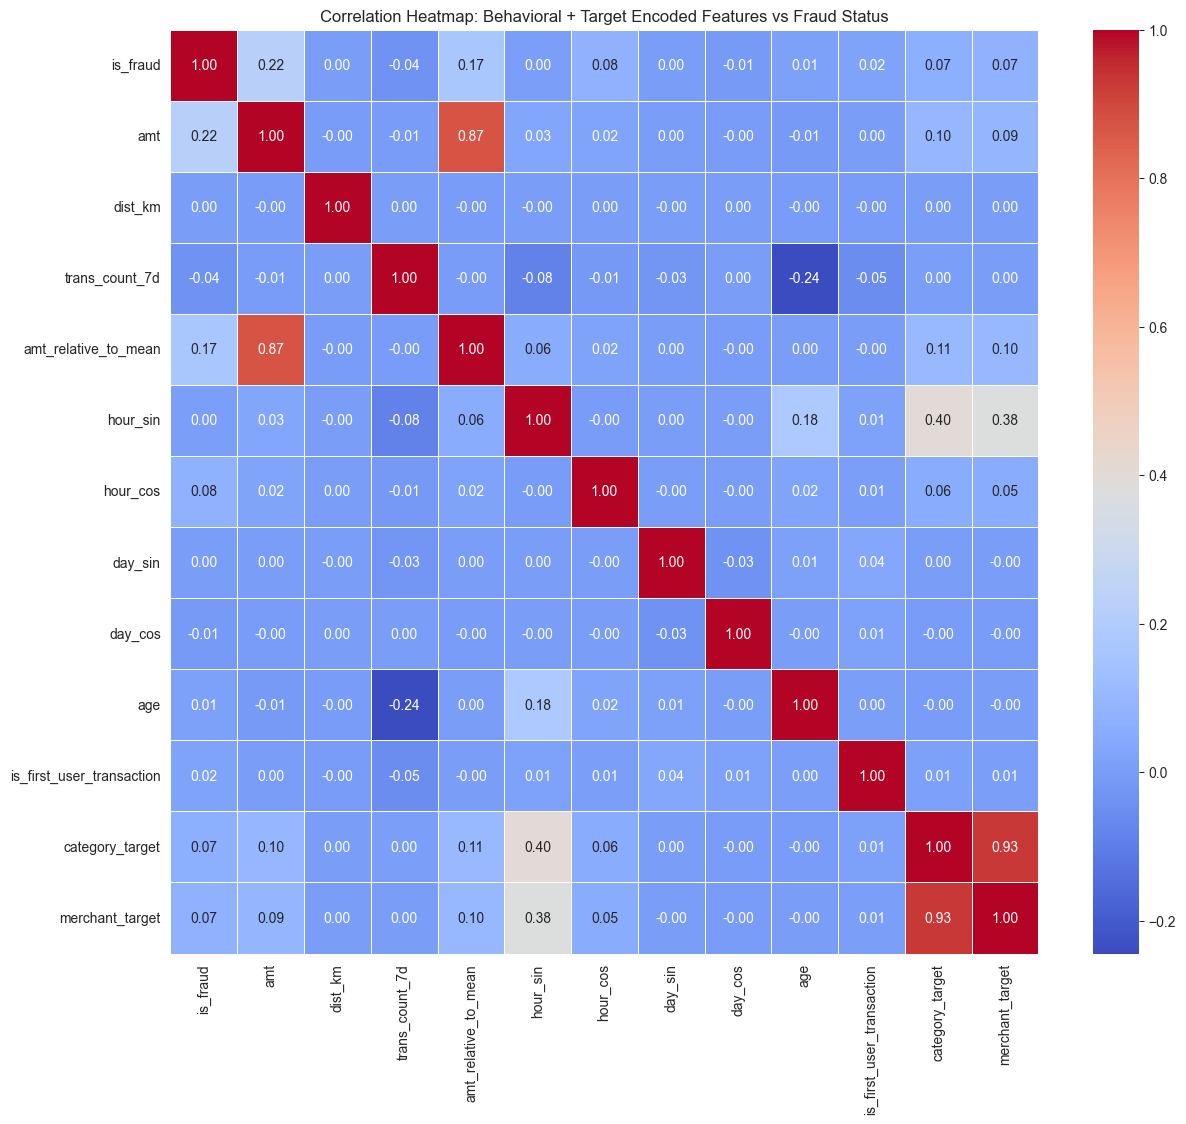

In [19]:
# Calculate correlation between all features and is_fraud
features_of_interest = [
    'is_fraud', 
    'amt', 'dist_km', 
    'trans_count_7d', 'amt_relative_to_mean', 
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
    'age', 'is_first_user_transaction',
    'category_target', 'merchant_target'
]

# Ensure we only use columns that exist (in case cell was re-run)
features_to_use = [c for c in features_of_interest if c in train_df_eng.columns]

if len(features_to_use) < len(features_of_interest):
    missing = set(features_of_interest) - set(features_to_use)
    print(f"Warning: The following features are missing: {missing}")

# Select only the relevant columns for correlation
corr_matrix = train_df_eng[features_to_use].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Behavioral + Target Encoded Features vs Fraud Status')
plt.show()

## 6. Data Preparation (Split & Shuffle)

In [20]:
# 1. Shuffle the training set
train_df_shuffled = train_df_eng.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Define Features (X) and Target (y)
target = 'is_fraud'
drop_cols = [target] # Already dropped date/time cols in feature engineering phase

X = train_df_shuffled.drop(columns=drop_cols)
y = train_df_shuffled[target]

# 3. Internal Train/Validation Split (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")
print(f"Fraud Rate in Train: {y_train.mean():.4f}")
print(f"Fraud Rate in Val: {y_val.mean():.4f}")

Training Set Shape: (838860, 13)
Validation Set Shape: (209715, 13)
Fraud Rate in Train: 0.0057
Fraud Rate in Val: 0.0057


## 7. XGBoost Model Training

In [21]:
# Calculate scale_pos_weight
num_legit = (y_train == 0).sum()
num_fraud = (y_train == 1).sum()
scale_weight = num_legit / num_fraud

print(f"Legit Cases: {num_legit}")
print(f"Fraud Cases: {num_fraud}")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

# Initialize XGBoost with cost-weighting
xgb_clf = xgb.XGBClassifier(
    max_depth=6,
    scale_pos_weight=scale_weight,
    tree_method='hist', # Faster training for large datasets
    random_state=42,
    objective='binary:logistic',
    eval_metric='aucpr' # Optimize for PR-AUC
)

print("Training XGBoost Model...")
xgb_clf.fit(X_train, y_train)
print("Training Complete.")

Legit Cases: 834055
Fraud Cases: 4805
Calculated scale_pos_weight: 173.58
Training XGBoost Model...
Training Complete.


## 8. Elite Evaluation (PR Curve & Recall)

Classification Report (Internal Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    208514
           1       0.57      0.96      0.72      1201

    accuracy                           1.00    209715
   macro avg       0.79      0.98      0.86    209715
weighted avg       1.00      1.00      1.00    209715



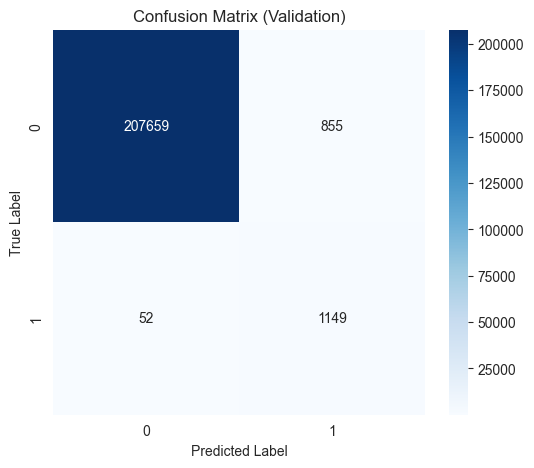

In [22]:
# Predict on Internal Validation Set
y_val_pred = xgb_clf.predict(X_val)

print("Classification Report (Internal Validation):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

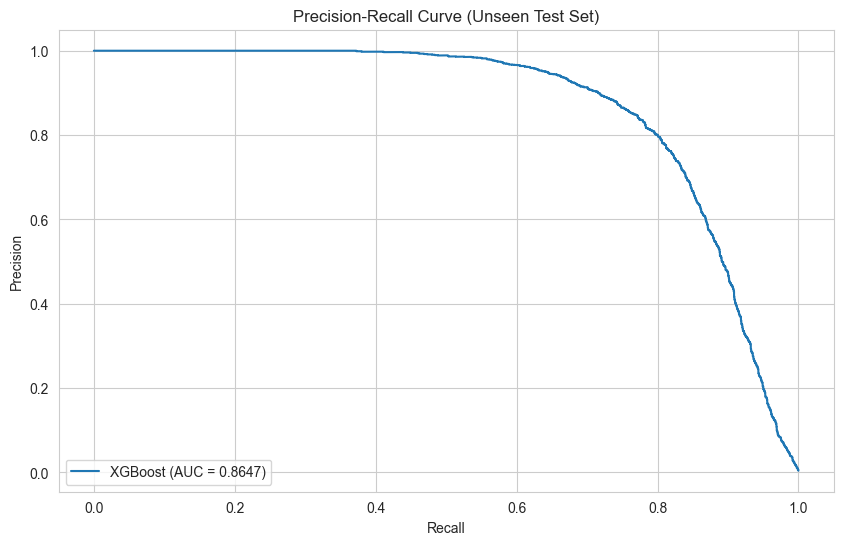

In [23]:
# Evaluate on UNSEEN Test Set (test_df_eng)
X_test_ext = test_df_eng.drop(columns=[target])
y_test_ext = test_df_eng[target]

y_test_pred_proba = xgb_clf.predict_proba(X_test_ext)[:, 1]

# Calculate PR Curve data
precision, recall, thresholds = precision_recall_curve(y_test_ext, y_test_pred_proba)
pr_auc = average_precision_score(y_test_ext, y_test_pred_proba)

# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'XGBoost (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Unseen Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## 9. Feature Importance (SHAP)

SHAP Summary Plot:


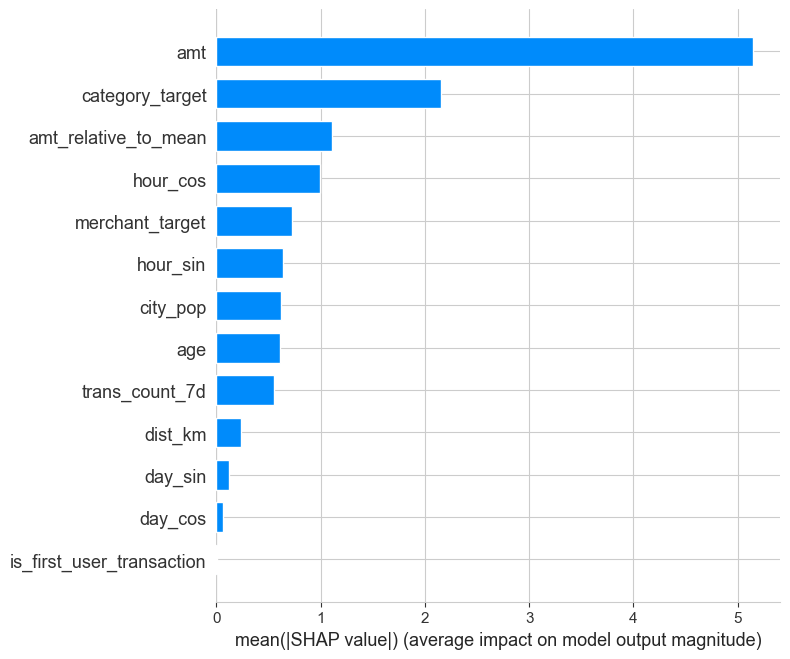

Detailed SHAP Dot Plot:


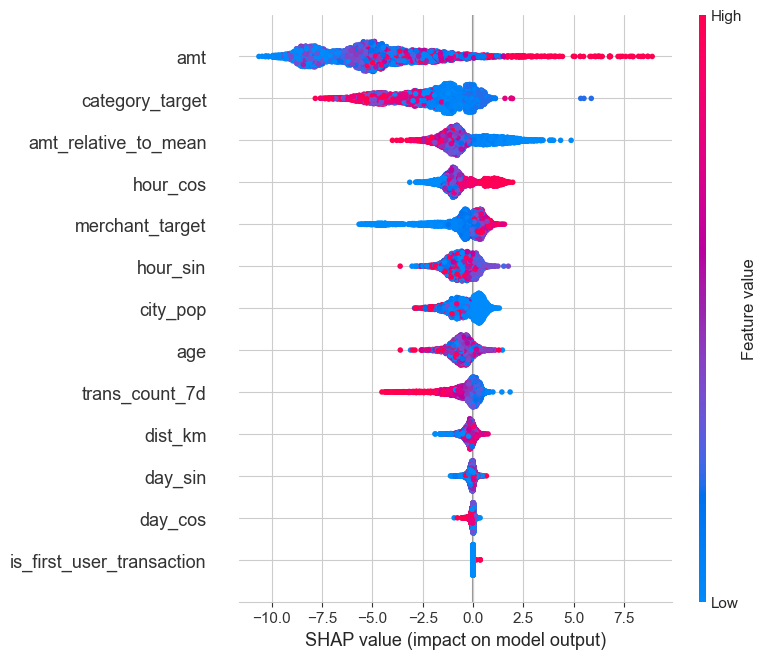

In [24]:
# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_clf)

# Calculate SHAP values for a subset of validation data (for speed)
# Using 5000 samples should be sufficient for overview
shap_values = explainer.shap_values(X_val.iloc[:5000])

print("SHAP Summary Plot:")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val.iloc[:5000], plot_type="bar")
plt.show()

print("Detailed SHAP Dot Plot:")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val.iloc[:5000])
plt.show()

# Phase 4: Cost-Benefit Optimization

optimizing threshold for maximum savings...
Optimal Threshold: 0.54
Max Savings (Validation Set): $558,460


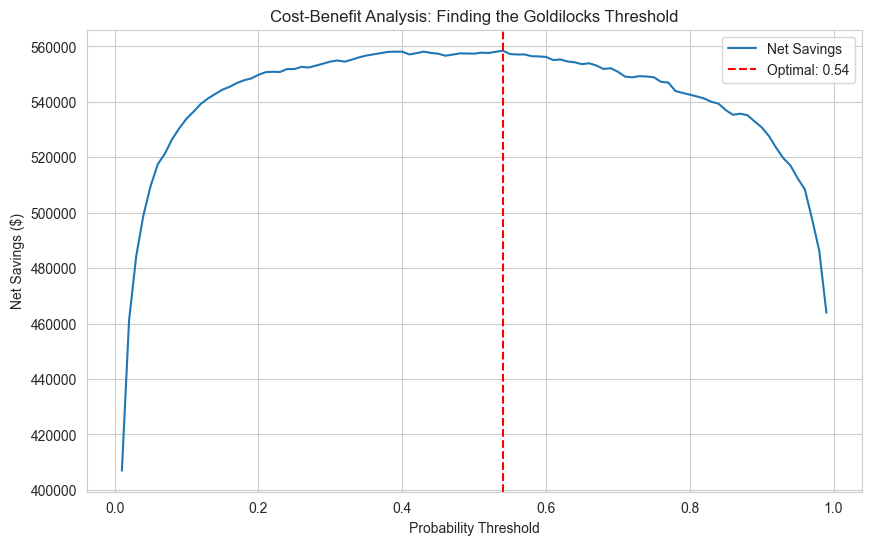

In [25]:
# Define Costs
COST_FN = -500  # Missed Fraud
COST_FP = -20   # False Alarm

# Predict probabilities on Validation Set
y_val_proba = xgb_clf.predict_proba(X_val)[:, 1]

thresholds_list = np.arange(0.01, 1.00, 0.01)
savings_list = []

print("optimizing threshold for maximum savings...")

for thresh in thresholds_list:
    # Convert proba to 0/1
    y_pred_thresh = (y_val_proba >= thresh).astype(int)
    
    # Calculate Confusion Matrix elements
    # TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_thresh).ravel()
    
    # Calculate Savings vs Baseline (Baseline = No Model, all Frauds missed)
    # Baseline Cost = Total Frauds * -500. 
    # Model Cost = (FN * -500) + (FP * -20)
    # Savings = Baseline Cost - Model Cost
    #         = (Total Frauds * -500) - (FN * -500 + FP * -20)
    #         = (TP + FN) * -500 + 500*FN + 20*FP
    # Wait, simpler logic: Every TP saves 500 (relative to missing it), Every FP costs 20.
    # Net Savings = (TP * 500) - (FP * 20)
    
    net_savings = (tp * 500) - (fp * 20)
    savings_list.append(net_savings)

# Find Optimal Threshold
max_savings = max(savings_list)
optimal_thresh = thresholds_list[savings_list.index(max_savings)]

print(f"Optimal Threshold: {optimal_thresh:.2f}")
print(f"Max Savings (Validation Set): ${max_savings:,.0f}")

# Plot the Money Shot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_list, savings_list, label='Net Savings')
plt.axvline(optimal_thresh, color='r', linestyle='--', label=f'Optimal: {optimal_thresh:.2f}')
plt.title('Cost-Benefit Analysis: Finding the Goldilocks Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Net Savings ($)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Final Evaluation on TEST SET using Optimal Threshold
y_test_pred_final = (y_test_pred_proba >= optimal_thresh).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test_ext, y_test_pred_final).ravel()
final_savings = (tp * 500) - (fp * 20)

print("--- Final Report ---")
print(f"Optimal Probability Threshold: {optimal_thresh:.2f}")
print(f"Total Test Set Savings: ${final_savings:,.2f}")
print(f"Frauds Caught (TP): {tp}")
print(f"False Alarms (FP): {fp}")
print(f"Missed Frauds (FN): {fn}")

--- Final Report ---
Optimal Probability Threshold: 0.54
Total Test Set Savings: $917,680.00
Frauds Caught (TP): 1906
False Alarms (FP): 1766
Missed Frauds (FN): 239
